# autoencoder experiment on dlbcl data set
applying autoencoder to dlbcl data to denoise and reveal important features. autoencoder follows the pipeline:
- build autoencoder with a few convolution layers
- train autoencoder on windows of original/ control matrix
- use trained autoencoder to decode query/ patient matrix, removing noise and revealing important features

## imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import fanc
import fanc.plotting
from scipy import ndimage as ndi
import matplotlib.patches as patches
from scipy.ndimage import zoom
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import math
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

## define helper functions

In [2]:
def clipped_zoom(img, zoom_factor, **kwargs):
    h, w = img.shape[:2]
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)
    if zoom_factor < 1:
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)
    elif zoom_factor > 1:
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]
    else:
        out = img
    return out

def highlight_features(dataframe, region, color, a, axes):
    try:
        features = dataframe.loc[region].values.tolist()
        if type(features[0]) == int:
            _, x_min, x_max, y_min, y_max = features
            rect = patches.Rectangle((x_min,y_min),x_max-x_min,y_max-y_min,linewidth=1.2,
                                     edgecolor=color, facecolor='none')
            axes[a].add_patch(rect)
        else:
            for f in features:
                _, x_min, x_max, y_min, y_max = f
                rect = patches.Rectangle((x_min,y_min),x_max-x_min,y_max-y_min,linewidth=1.2,
                                         edgecolor=color, facecolor='none')
                axes[a].add_patch(rect)
                
    except KeyError:
        next

def mean_squared_error(original: np.array, denoised: np.array) -> float:
    return np.mean((original - denoised) ** 2)

def clip_rotate(matrix):
    zm = clipped_zoom(matrix, 0.7)
    rot_clipped = ndi.rotate(zm, 45, reshape=False)
    return rot_clipped

## autoencoder function

In [3]:
# Build Autoencoder
def build_autoencoder(input_dim, encoding_dim):
    model = Sequential()
    model.add(Dense(encoding_dim, input_dim=input_dim, activation='relu'))
    model.add(Dense(input_dim, activation='linear'))  # Linear output activation
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def apply_autoencoder(matrix, encode_dim):
    model = build_autoencoder(input_dim=len(matrix), encoding_dim=encode_dim)
    # Normalize the matrix
    scaler = MinMaxScaler()
    matrix_scaled = scaler.fit_transform(matrix)
    
    model.fit(matrix_scaled, matrix_scaled, epochs=50, batch_size=32)
    denoised_matrix_scaled = model.predict(matrix_scaled) # denoise
    
    denoised_matrix = scaler.inverse_transform(denoised_matrix_scaled) # rescale
    return denoised_matrix

## load hic data

In [4]:
winsize = "3mb"
wdir = "../data/dlbcl/"
region_pairs = "hg38_chr2_{}_win_100kb_step.bed".format(winsize)

gained = pd.read_csv(wdir + 'gained_features.tsv', delimiter=',', usecols=[0, 1, 2, 3, 4, 5], header=None, index_col=[0])
lost = pd.read_csv(wdir + 'lost_features.tsv', delimiter=',', usecols=[0, 1, 2, 3, 4, 5], header=None, index_col=[0])

regions = pd.read_csv(wdir + region_pairs, sep='\t', header=None)

patient_hic = fanc.load(wdir + "ukm_patient_fixed_le_25kb_chr2.hic")
control_hic = fanc.load(wdir + "ukm_control_fixed_le_25kb_chr2.hic")

reg = 1448

window_start, window_end = regions.loc[reg][1:3]

region_string = "chr2:{}-{}".format(window_start, window_end)

patient_region_sub = patient_hic[region_string, region_string].data
control_region_sub = control_hic[region_string, region_string].data

min_v = min(
    [
        np.min(np.extract(patient_region_sub>0 , patient_region_sub)),
        np.min(np.extract(control_region_sub>0 , control_region_sub))
    ]
)

patient_region_sub += min_v
control_region_sub += min_v
print("loaded hic")

loaded hic


## apply autoencoder to hic data

In [5]:
# set size of encoding dim, should be some fraction of input matrix size
latent_space_size = 40

# raw matrices
rot_patient = clip_rotate(patient_region_sub)

rot_control = clip_rotate(control_region_sub)

# ------ apply autoencoder ------
auto_patient = apply_autoencoder(patient_region_sub, latent_space_size)
rot_auto1 = clip_rotate(auto_patient)

auto_control = apply_autoencoder(control_region_sub, latent_space_size)
rot_auto2 = clip_rotate(auto_control)

# Compute autoencoder difference matrix (patient - control)
diff_auto1 = auto_patient - auto_control # pca_matrix1 - pca_matrix2
rot_diff_auto1 = clip_rotate(diff_auto1)

# subtract inverse (control - patient)
diff_auto2 = auto_control - auto_patient
rot_diff_auto2 = clip_rotate(diff_auto2)

# log2(obs/exp) calc
safe_div = auto_patient / auto_control

safe_div[safe_div == 0] = np.nan
safe_div = abs(safe_div)
log_auto1 =  np.log2(safe_div) # pca_matrix1 / pca_matrix2 of pca applied
rot_log_auto1 = clip_rotate(log_auto1)

log_auto2 =  np.log2(patient_region_sub / control_region_sub) # patient / control of normal matrices
rot_log_auto2 = clip_rotate(log_auto2)

Epoch 1/50


/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0413  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0359 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0333 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0306 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0290 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0276 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0253 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0243 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0233 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0224 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0214 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0205 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0199 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0189 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0389  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0340 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0303 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0286 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0268 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0258 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0241 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0235 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0229 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0223 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0216 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0211 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0207 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0200 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

## generate plots

Plot saved to out/all_autoencoder_hic.png


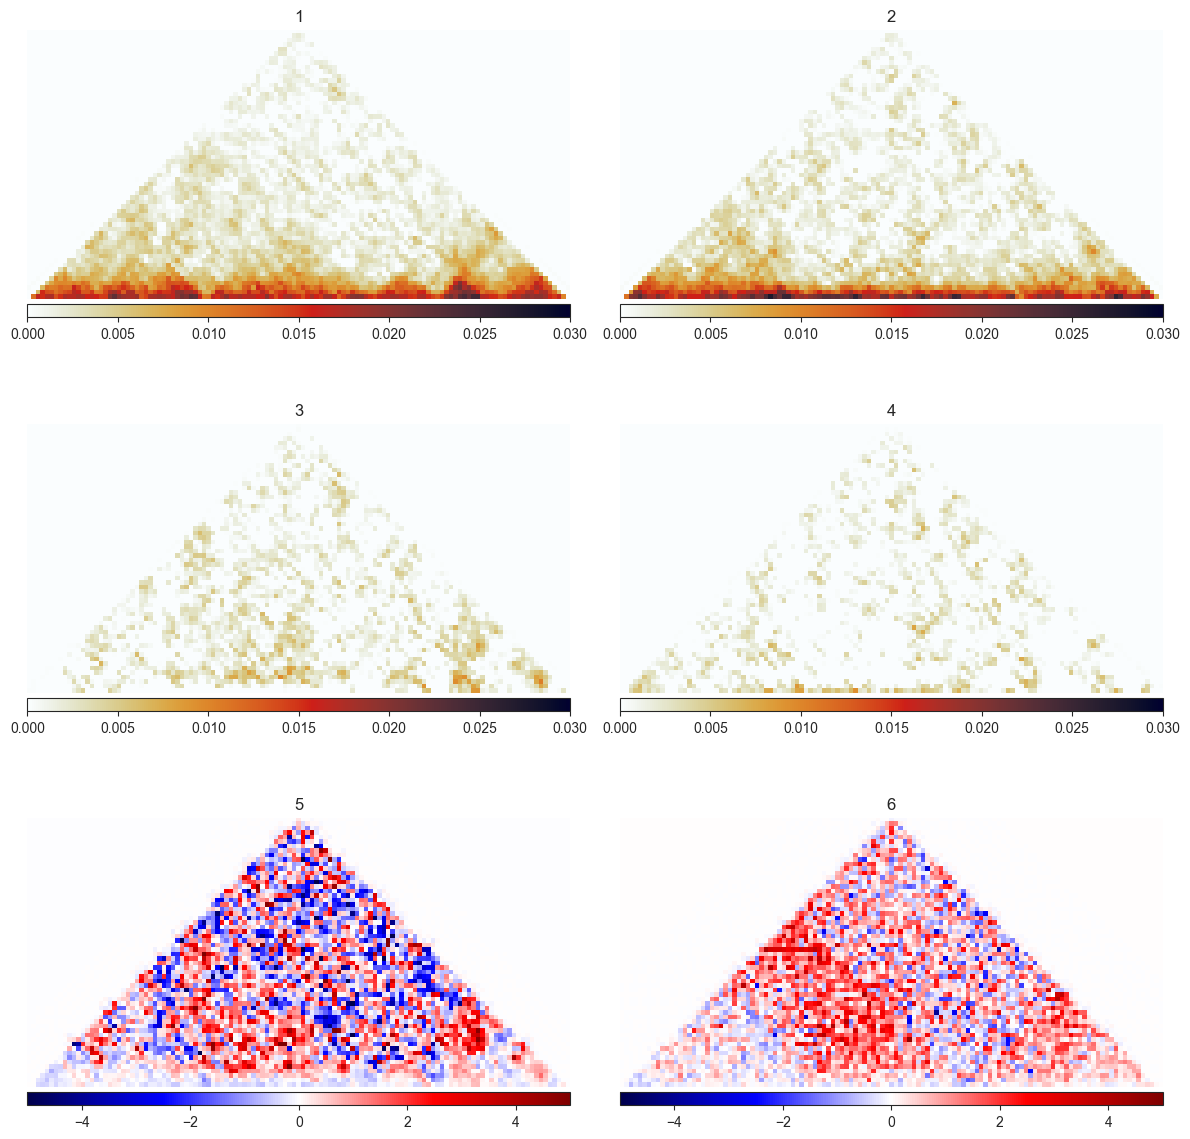

In [6]:
# Plot heatmaps in a grid layout
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

middle = int(np.shape(rot_control)[1]/ 2.)

# Second row: PCA transformed matrices
m1 = axes[0][0].imshow(rot_auto1[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[0, 0].set_title("1")

m2 = axes[0][1].imshow(rot_auto2[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[0, 1].set_title("2")

# Third row: Difference matrix spanning two columns
m3 = axes[1][0].imshow(rot_diff_auto1[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[1, 0].set_title("3")

m4 = axes[1][1].imshow(rot_diff_auto2[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[1, 1].set_title("4")

# Fourth Row:
# apply log2(obs/exp) from pca modified matrices and raw matrices
m5 = axes[2][0].imshow(rot_log_auto1[:middle, :], vmin=-5, vmax=5, cmap='seismic')
axes[2, 0].set_title("5")

m6 = axes[2][1].imshow(rot_log_auto2[:middle, :], vmin=-5, vmax=5, cmap='seismic')
axes[2, 1].set_title("6")

color_bars = [m1, m2, m3, m4, m5, m6]

for i in range(0, len(axes)):
    for m, ax in zip([color_bars[i*2+1], color_bars[i*2+1]], axes[i]):
        ax.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        fig.colorbar(m, cax=cax, orientation='horizontal') 

# Adjust layout
plt.tight_layout()

# save plot
save_path = os.path.join("out", "all_autoencoder_hic.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High resolution and tight layout

print(f"Plot saved to {save_path}")
# TODO mse value calc
# mse_value = mean_squared_error(pca_matrix1, patient_region_sub)
# print(f"mse value {mse_value}")

## concentrated plots
include neccessary plots in one figure

Plot saved to out/autoencoder_hic.png


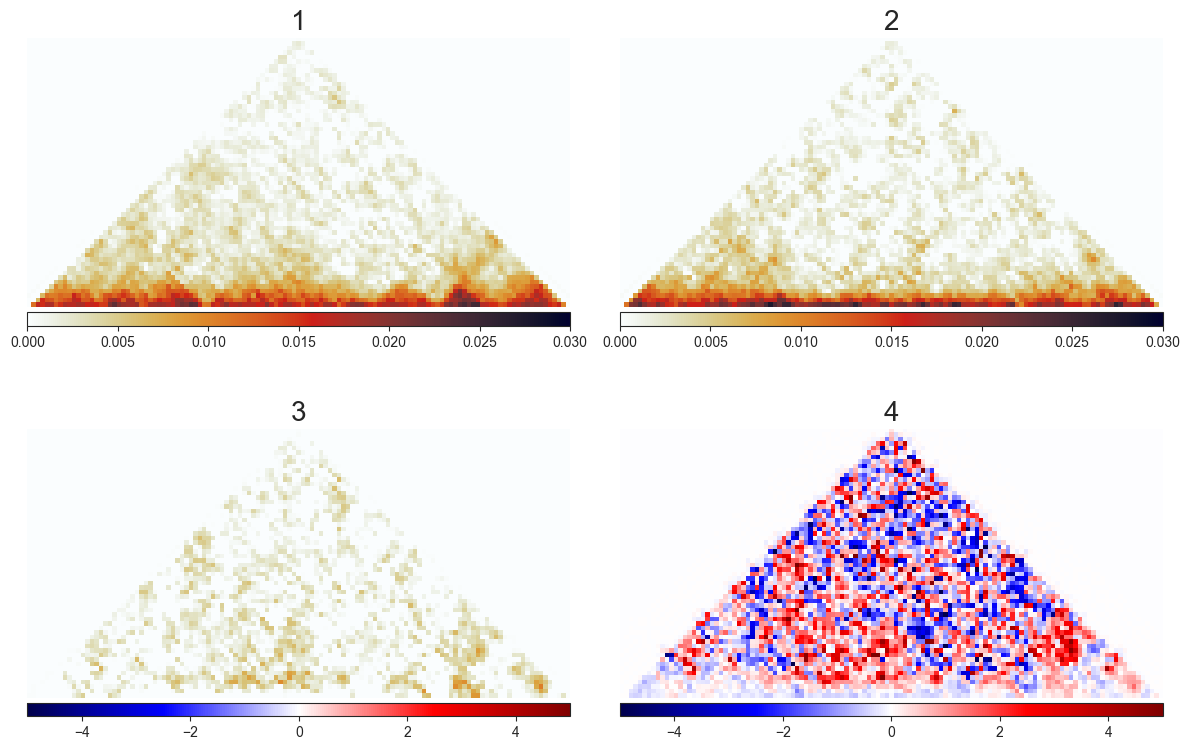

In [7]:
# Plot heatmaps in a grid layout
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

middle = int(np.shape(rot_control)[1]/ 2.)

# First row: autoencoder transformed matrices
m1 = axes[0][0].imshow(rot_auto1[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[0, 0].set_title("1", fontsize=20)

m2 = axes[0][1].imshow(rot_auto2[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[0, 1].set_title("2", fontsize=20)

# Second row: Difference matrix spanning two columns
m3 = axes[1][0].imshow(rot_diff_auto1[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[1, 0].set_title("3", fontsize=20)

m4 = axes[1][1].imshow(rot_log_auto1[:middle, :], vmin=-5, vmax=5, cmap='seismic')
axes[1, 1].set_title("4", fontsize=20)

color_bars = [m1, m2, m3, m4]

for i in range(0, len(axes)):
    for m, ax in zip([color_bars[i*2+1], color_bars[i*2+1]], axes[i]):
        ax.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        fig.colorbar(m, cax=cax, orientation='horizontal') 

# Adjust layout
plt.tight_layout()

# save plot
save_path = os.path.join("out", "autoencoder_hic.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High resolution and tight layout

print(f"Plot saved to {save_path}")
# TODO mse value calc
# mse_value = mean_squared_error(pca_matrix1, patient_region_sub)
# print(f"mse value {mse_value}")